## Cluster Analysis

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("/home/anisa_bakiu/Downloads/DM_progetto/pre-elaborazione/em_processed.csv")

In [4]:
df.head()

,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,Subregion,Total Deaths,No. Injured,No. Affected,Total Affected,"Total Damage, Adjusted ('000 US$)",duration_days
0,Natural,Meteorological,Storm,Tropical cyclone,United States of America,Northern America,6000.0,4874.178387,484619.025458,486890.607839,1.131126e+06,1.0
1,Technological,Industrial accident,Fire (Industrial),Fire (Industrial),United States of America,Northern America,300.0,985.002101,478641.647996,486365.632384,1.301184e+06,1.0
2,Natural,Hydrological,Flood,Flood (General),Jamaica,Latin America and the Caribbean,300.0,985.002101,478641.647996,486365.632384,1.301184e+06,1.0
3,Natural,Biological,Epidemic,Viral disease,Jamaica,Latin America and the Caribbean,30.0,778.143587,478349.035299,486293.451420,1.299306e+06,1.0
4,Natural,Geophysical,Volcanic activity,Ash fall,Japan,Eastern Asia,30.0,778.143587,478349.035299,486293.451420,1.299306e+06,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27262 entries, 0 to 27261
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Disaster Group                     27262 non-null  object 
 1   Disaster Subgroup                  27262 non-null  object 
 2   Disaster Type                      27262 non-null  object 
 3   Disaster Subtype                   27262 non-null  object 
 4   Country                            27262 non-null  object 
 5   Subregion                          27262 non-null  object 
 6   Total Deaths                       27262 non-null  float64
 7   No. Injured                        27262 non-null  float64
 8   No. Affected                       27262 non-null  float64
 9   Total Affected                     27262 non-null  float64
 10  Total Damage, Adjusted ('000 US$)  27262 non-null  float64
 11  duration_days                      27262 non-null  flo

## Standardizzazione dei dati

In [6]:
df.columns.to_list()

['Disaster Group',
 'Disaster Subgroup',
 'Disaster Type',
 'Disaster Subtype',
 'Country',
 'Subregion',
 'Total Deaths',
 'No. Injured',
 'No. Affected',
 'Total Affected',
 "Total Damage, Adjusted ('000 US$)",
 'duration_days']

In [7]:
df_numeric = df[[
 'Total Deaths',
 'No. Injured',
 'No. Affected',
 'Total Affected',
 "Total Damage, Adjusted ('000 US$)",
 'duration_days']]

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_scaled = pd.DataFrame(
    scaler.fit_transform(df_numeric),
    columns=df_numeric.columns,
    index=df_numeric.index
)

In [9]:
df_scaled.describe()

,Total Deaths,No. Injured,No. Affected,Total Affected,"Total Damage, Adjusted ('000 US$)",duration_days
count,2.726200e+04,2.726200e+04,2.726200e+04,2.726200e+04,2.726200e+04,2.726200e+04
mean,-2.085079e-18,-4.170158e-18,2.085079e-18,7.297776e-18,6.255236e-18,2.241460e-17
std,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00
min,-5.247480e-01,-2.333599e+00,-2.635123e-01,-9.599076e-02,-1.710448e+00,-8.861385e-02
25%,-3.497277e-02,-5.270250e-02,-9.553214e-02,-9.593828e-02,-5.146009e-02,-8.861385e-02
50%,-3.461332e-02,-3.577826e-02,-9.170008e-02,-9.204515e-02,-1.387546e-02,-8.861385e-02
75%,-3.133341e-02,-3.149590e-02,-3.104052e-04,-5.065650e-05,-2.649865e-03,-8.306026e-02
max,8.308583e+01,7.722262e+01,6.561056e+01,6.500981e+01,1.033368e+02,1.419390e+02


## Funzione di Fine Tuning degli iperparametri

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

def fineTuning(X, model_class, param_grid):
    results = []

    for params in ParameterGrid(param_grid):
        model = model_class(**params)
        model.fit(X)

        # Ottengo le etichette 
        if hasattr(model, "labels_"):  
            labels = model.labels_
        else:  # GMM e altri modelli senza labels_
            labels = model.predict(X)

        # Calcola silhouette score solo se ci sono almeno 2 cluster
        if len(set(labels)) > 1:
            sil = silhouette_score(X, labels)
        else:
            sil = np.nan

        results.append({
            "params": params,
            "silhouette": sil,
            "n_clusters": len(set(labels))
        })

    df = pd.DataFrame(results)
    best_idx = df["silhouette"].idxmax()
    best_params = df.loc[best_idx, "params"]

    return best_params, df

## K-Means

### Tuning

In [46]:
from sklearn.cluster import KMeans

param_grid = {
    'n_clusters': [2, 3, 4],
    'init': ['k-means++', 'random'],
}

best_params, results_df = fineTuning(df_numeric, KMeans, param_grid)
display("Best parameters:", best_params)

'Best parameters:'

{'init': 'k-means++', 'n_clusters': 3}

### Analisi con i parametri migliori

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

model = KMeans(
    n_clusters=best_params['n_clusters'],
    init=best_params['init']
).fit(df_numeric)

labels = model.predict(df_numeric)

sil_score = silhouette_score(df_numeric, labels)
display(f"Silhouette Score: {sil_score:.4f}")

'Silhouette Score: 0.9925'

### Visualizzazione dei clusters tramite PCA

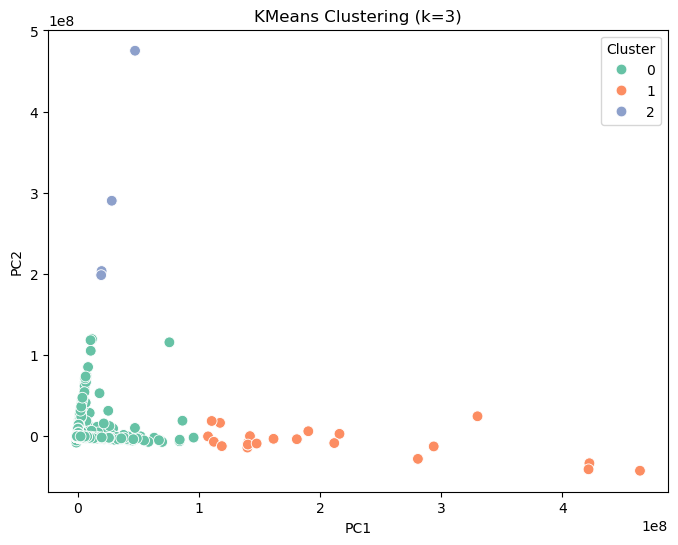

In [48]:
from sklearn.decomposition import PCA

# Riduzione a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_numeric)

# Scatter plot colorato per cluster
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='Set2', s=60)
plt.title(f'KMeans Clustering (k={best_params["n_clusters"]})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

In [53]:
# Aggiungi le etichette dei cluster al DataFrame
df_clustered = df.copy()
df_clustered['Cluster'] = labels

# filtrare e vedere tutte le righe di ciascun cluster
for cluster_num in sorted(df_clustered['Cluster'].unique()):
    print(f"\n=== Cluster {cluster_num} ===")
    display(df_clustered[df_clustered['Cluster'] == cluster_num])


=== Cluster 0 ===


,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,Subregion,Total Deaths,No. Injured,No. Affected,Total Affected,"Total Damage, Adjusted ('000 US$)",duration_days,Cluster
0,Natural,Meteorological,Storm,Tropical cyclone,United States of America,Northern America,6000.000000,4874.178387,4.846190e+05,4.868906e+05,1.131126e+06,1.0,0
1,Technological,Industrial accident,Fire (Industrial),Fire (Industrial),United States of America,Northern America,300.000000,985.002101,4.786416e+05,4.863656e+05,1.301184e+06,1.0,0
2,Natural,Hydrological,Flood,Flood (General),Jamaica,Latin America and the Caribbean,300.000000,985.002101,4.786416e+05,4.863656e+05,1.301184e+06,1.0,0
3,Natural,Biological,Epidemic,Viral disease,Jamaica,Latin America and the Caribbean,30.000000,778.143587,4.783490e+05,4.862935e+05,1.299306e+06,1.0,0
4,Natural,Geophysical,Volcanic activity,Ash fall,Japan,Eastern Asia,30.000000,778.143587,4.783490e+05,4.862935e+05,1.299306e+06,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27257,Natural,Hydrological,Flood,Flood (General),Ukraine,Eastern Europe,9.000000,633.607917,2.010000e+03,2.010000e+03,1.246058e+06,1.0,0
27258,Natural,Hydrological,Flood,Flood (General),Bulgaria,Eastern Europe,4.000000,630.184719,1.000000e+02,1.000000e+02,1.245953e+06,1.0,0
27259,Natural,Climatological,Drought,Drought,Somalia,Sub-Saharan Africa,27.000000,482.000000,-1.373772e+03,4.820000e+02,1.193732e+06,181.0,0
27260,Natural,Climatological,Drought,Drought,Kenya,Sub-Saharan Africa,3231.125945,2572.237988,2.150000e+06,2.150000e+06,1.335056e+06,1.0,0



=== Cluster 1 ===


,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,Subregion,Total Deaths,No. Injured,No. Affected,Total Affected,"Total Damage, Adjusted ('000 US$)",duration_days,Cluster
1571,Natural,Climatological,Drought,Drought,India,Southern Asia,1.500000e+06,1.119677e+06,100000000.0,100000000.0,9.955750e+05,730.0,1
2204,Natural,Climatological,Drought,Drought,India,Southern Asia,1.851657e+05,7.384170e+04,200000000.0,200000000.0,7.501530e+05,366.0,1
3620,Natural,Climatological,Drought,Drought,India,Southern Asia,9.127521e+04,4.443534e+04,100000000.0,100000000.0,4.778316e+06,214.0,1
4967,Natural,Climatological,Drought,Drought,India,Southern Asia,3.000000e+02,-8.378176e+04,300000000.0,300000000.0,9.129036e+06,92.0,1
5414,Natural,Hydrological,Flood,Flood (General),China,Eastern Asia,2.000000e+03,1.000000e+04,100000000.0,100010000.0,7.057368e+06,1.0,1
6360,Natural,Hydrological,Flood,Riverine flood,China,Eastern Asia,1.729000e+03,3.222700e+04,206000000.0,210232227.0,1.727468e+07,48.0,1
7176,Natural,Hydrological,Flood,Flood (General),India,Southern Asia,8.270000e+02,-1.172616e+04,128000000.0,128000000.0,1.520039e+07,23.0,1
7631,Natural,Hydrological,Flood,Riverine flood,China,Eastern Asia,1.001000e+03,1.440000e+04,73360000.0,78974400.0,1.155501e+07,16.0,1
8008,Natural,Climatological,Drought,Drought,China,Eastern Asia,6.454282e+04,8.353848e+04,82000000.0,82000000.0,2.911016e+07,334.0,1
8143,Natural,Hydrological,Flood,Riverine flood,China,Eastern Asia,1.437000e+03,7.024900e+04,114400000.0,114470249.0,1.383347e+07,92.0,1



=== Cluster 2 ===


,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,Subregion,Total Deaths,No. Injured,No. Affected,Total Affected,"Total Damage, Adjusted ('000 US$)",duration_days,Cluster
8031,Natural,Geophysical,Earthquake,Ground movement,Japan,Eastern Asia,5297.0,3.449200e+04,255843.0,541636.0,2.058551e+08,1.0,2
14260,Natural,Meteorological,Extreme temperature,Cold wave,Peru,Latin America and the Caribbean,90.0,1.800000e+06,337467.0,2137467.0,4.787113e+08,30.0,2
15176,Natural,Meteorological,Storm,Tropical cyclone,United States of America,Northern America,1833.0,4.398515e+05,500000.0,500000.0,2.007823e+08,21.0,2
19056,Natural,Geophysical,Earthquake,Tsunami,Japan,Eastern Asia,19846.0,5.933000e+03,362887.0,368820.0,2.928555e+08,1.0,2


### Visualizzazione del Silhouette score 

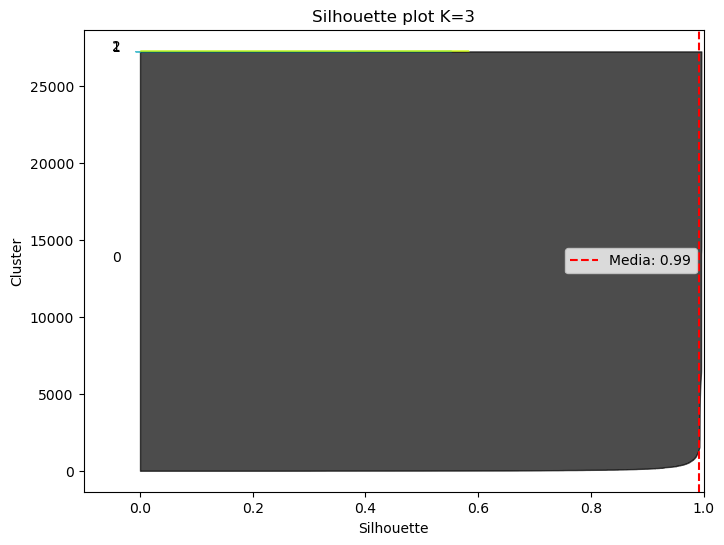

In [52]:
n_clusters = model.n_clusters

# Silhouette values
sil_vals = silhouette_samples(df_numeric, labels)

# Plot
fig, ax = plt.subplots(figsize=(8,6))
y_lower = 10
for i in range(n_clusters):
    vals = np.sort(sil_vals[labels==i])
    y_upper = y_lower + len(vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals, alpha=0.7, color=cm.nipy_spectral(i/n_clusters))
    ax.text(-0.05, y_lower + len(vals)/2, str(i))
    y_lower = y_upper + 10

ax.axvline(sil_score, color="red", linestyle="--", label=f"Media: {sil_score:.2f}")
ax.set_xlim([-0.1, 1])
ax.set_xlabel("Silhouette")
ax.set_ylabel("Cluster")
ax.set_title(f"Silhouette plot K={n_clusters}")
ax.legend()
plt.show()


## GMM

In [54]:
from sklearn.mixture import GaussianMixture

param_grid = {
    'n_components': [2, 3, 4],
    'covariance_type': ['full', 'tied', 'diag'], 
    #'max_iter': [100, 200, 300],  
    #'init_params': ['kmeans', 'random'], 
    #'tol': [1e-3, 1e-4]
}

best_params, results_df = fineTuning(df_numeric, GaussianMixture, param_grid)
print("Best parameters:", best_params)

Best parameters: {'covariance_type': 'tied', 'n_components': 2}


In [ ]:
# Eseguo GMM con i parametri ottimali trovati
gmm = GaussianMixture(
    n_components = best_params['n_components'],
    covariance_type = best_params['covariance_type'],
    random_state=42
)
gmm.fit(df_numeric)

# Ottengo le etichette dei cluster
labels_gmm = gmm.predict(df_numeric)

sil_score = silhouette_score(df_numeric, labels_gmm)
display(f"Silhouette Score: {sil_score:.4f}")

'Silhouette Score: 0.9922'

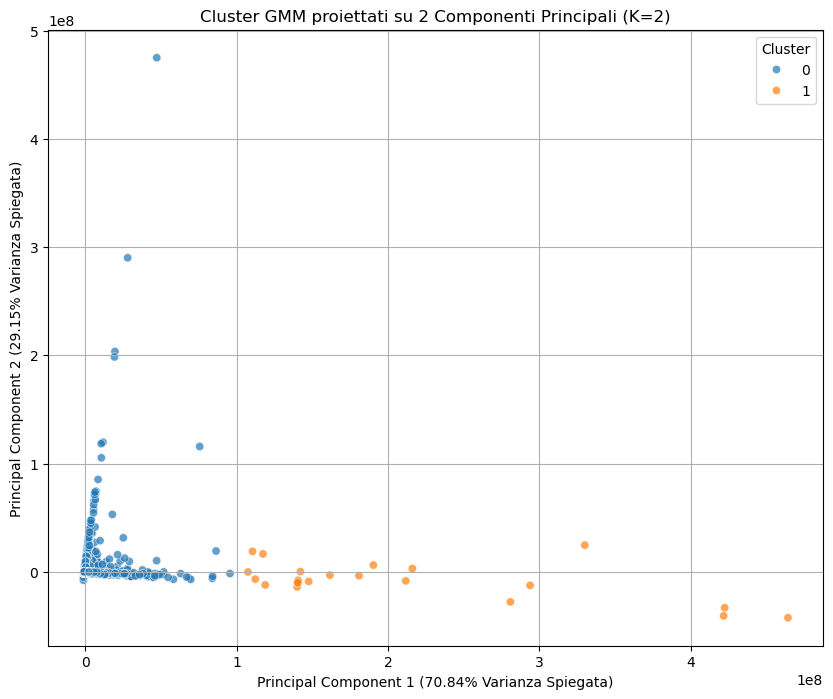

In [57]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_numeric)

pca_df = pd.DataFrame(
    data=principal_components,
    columns=['Principal Component 1', 'Principal Component 2']
)

pca_df['Cluster'] = labels_gmm

plt.figure(figsize=(10, 8))


sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='Cluster', # Colora i punti in base al cluster
    data=pca_df,
    palette=sns.color_palette("tab10", n_colors=gmm.n_components), # Imposta i colori
    legend='full',
    alpha=0.7 # Trasparenza per visualizzare le sovrapposizioni
)

# Aggiungo il titolo e le etichette
plt.title(f'Cluster GMM proiettati su 2 Componenti Principali (K={gmm.n_components})')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Varianza Spiegata)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Varianza Spiegata)')

# Mostro il grafico
plt.grid(True)
plt.show()

In [58]:
# Copia del DataFrame originale con etichette dei cluster
df_clustered_gmm = df.copy()
df_clustered_gmm['Cluster'] = labels_gmm

# Visualizzare tutte le righe di ciascun cluster
for cluster_num in sorted(df_clustered_gmm['Cluster'].unique()):
    print(f"\n=== Cluster {cluster_num} ===")
    display(df_clustered_gmm[df_clustered_gmm['Cluster'] == cluster_num])



=== Cluster 0 ===


,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,Subregion,Total Deaths,No. Injured,No. Affected,Total Affected,"Total Damage, Adjusted ('000 US$)",duration_days,Cluster
0,Natural,Meteorological,Storm,Tropical cyclone,United States of America,Northern America,6000.000000,4874.178387,4.846190e+05,4.868906e+05,1.131126e+06,1.0,0
1,Technological,Industrial accident,Fire (Industrial),Fire (Industrial),United States of America,Northern America,300.000000,985.002101,4.786416e+05,4.863656e+05,1.301184e+06,1.0,0
2,Natural,Hydrological,Flood,Flood (General),Jamaica,Latin America and the Caribbean,300.000000,985.002101,4.786416e+05,4.863656e+05,1.301184e+06,1.0,0
3,Natural,Biological,Epidemic,Viral disease,Jamaica,Latin America and the Caribbean,30.000000,778.143587,4.783490e+05,4.862935e+05,1.299306e+06,1.0,0
4,Natural,Geophysical,Volcanic activity,Ash fall,Japan,Eastern Asia,30.000000,778.143587,4.783490e+05,4.862935e+05,1.299306e+06,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27257,Natural,Hydrological,Flood,Flood (General),Ukraine,Eastern Europe,9.000000,633.607917,2.010000e+03,2.010000e+03,1.246058e+06,1.0,0
27258,Natural,Hydrological,Flood,Flood (General),Bulgaria,Eastern Europe,4.000000,630.184719,1.000000e+02,1.000000e+02,1.245953e+06,1.0,0
27259,Natural,Climatological,Drought,Drought,Somalia,Sub-Saharan Africa,27.000000,482.000000,-1.373772e+03,4.820000e+02,1.193732e+06,181.0,0
27260,Natural,Climatological,Drought,Drought,Kenya,Sub-Saharan Africa,3231.125945,2572.237988,2.150000e+06,2.150000e+06,1.335056e+06,1.0,0



=== Cluster 1 ===


,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,Subregion,Total Deaths,No. Injured,No. Affected,Total Affected,"Total Damage, Adjusted ('000 US$)",duration_days,Cluster
1571,Natural,Climatological,Drought,Drought,India,Southern Asia,1.500000e+06,1.119677e+06,100000000.0,100000000.0,9.955750e+05,730.0,1
2204,Natural,Climatological,Drought,Drought,India,Southern Asia,1.851657e+05,7.384170e+04,200000000.0,200000000.0,7.501530e+05,366.0,1
3620,Natural,Climatological,Drought,Drought,India,Southern Asia,9.127521e+04,4.443534e+04,100000000.0,100000000.0,4.778316e+06,214.0,1
4967,Natural,Climatological,Drought,Drought,India,Southern Asia,3.000000e+02,-8.378176e+04,300000000.0,300000000.0,9.129036e+06,92.0,1
5414,Natural,Hydrological,Flood,Flood (General),China,Eastern Asia,2.000000e+03,1.000000e+04,100000000.0,100010000.0,7.057368e+06,1.0,1
6360,Natural,Hydrological,Flood,Riverine flood,China,Eastern Asia,1.729000e+03,3.222700e+04,206000000.0,210232227.0,1.727468e+07,48.0,1
7176,Natural,Hydrological,Flood,Flood (General),India,Southern Asia,8.270000e+02,-1.172616e+04,128000000.0,128000000.0,1.520039e+07,23.0,1
7631,Natural,Hydrological,Flood,Riverine flood,China,Eastern Asia,1.001000e+03,1.440000e+04,73360000.0,78974400.0,1.155501e+07,16.0,1
8008,Natural,Climatological,Drought,Drought,China,Eastern Asia,6.454282e+04,8.353848e+04,82000000.0,82000000.0,2.911016e+07,334.0,1
8143,Natural,Hydrological,Flood,Riverine flood,China,Eastern Asia,1.437000e+03,7.024900e+04,114400000.0,114470249.0,1.383347e+07,92.0,1


## Agglomerative Clustering

In [62]:
from sklearn.cluster import AgglomerativeClustering

param_grid = {
    'n_clusters': [2, 3, 4],
    'metric': ['euclidean', 'manhattan'],  
    'linkage': ['complete', 'average', 'single']
}

best_params, results_df = fineTuning(df_numeric, AgglomerativeClustering, param_grid)
print("Best parameters:", best_params)

Best parameters: {'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 2}


In [63]:
model = AgglomerativeClustering(
    n_clusters=best_params['n_clusters'],
    metric=best_params['metric'],
    linkage=best_params['linkage']
).fit(df_numeric)

labels = model.labels_

sil_score = silhouette_score(df_numeric, labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.9961


In [ ]:
# Copia del DataFrame originale con etichette dei cluster
df_clustered_agg = df.copy()
df_clustered_agg['Cluster'] = labels

# Visualizzare tutte le righe di ciascun cluster
for cluster_num in sorted(df_clustered_agg['Cluster'].unique()):
    print(f"\n=== Cluster {cluster_num} ===")
    display(df_clustered_agg[df_clustered_agg['Cluster'] == cluster_num])


=== Cluster 0 ===


,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,Subregion,Total Deaths,No. Injured,No. Affected,Total Affected,"Total Damage, Adjusted ('000 US$)",duration_days,Cluster
0,Natural,Meteorological,Storm,Tropical cyclone,United States of America,Northern America,6000.000000,4874.178387,4.846190e+05,4.868906e+05,1.131126e+06,1.0,0
1,Technological,Industrial accident,Fire (Industrial),Fire (Industrial),United States of America,Northern America,300.000000,985.002101,4.786416e+05,4.863656e+05,1.301184e+06,1.0,0
2,Natural,Hydrological,Flood,Flood (General),Jamaica,Latin America and the Caribbean,300.000000,985.002101,4.786416e+05,4.863656e+05,1.301184e+06,1.0,0
3,Natural,Biological,Epidemic,Viral disease,Jamaica,Latin America and the Caribbean,30.000000,778.143587,4.783490e+05,4.862935e+05,1.299306e+06,1.0,0
4,Natural,Geophysical,Volcanic activity,Ash fall,Japan,Eastern Asia,30.000000,778.143587,4.783490e+05,4.862935e+05,1.299306e+06,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27257,Natural,Hydrological,Flood,Flood (General),Ukraine,Eastern Europe,9.000000,633.607917,2.010000e+03,2.010000e+03,1.246058e+06,1.0,0
27258,Natural,Hydrological,Flood,Flood (General),Bulgaria,Eastern Europe,4.000000,630.184719,1.000000e+02,1.000000e+02,1.245953e+06,1.0,0
27259,Natural,Climatological,Drought,Drought,Somalia,Sub-Saharan Africa,27.000000,482.000000,-1.373772e+03,4.820000e+02,1.193732e+06,181.0,0
27260,Natural,Climatological,Drought,Drought,Kenya,Sub-Saharan Africa,3231.125945,2572.237988,2.150000e+06,2.150000e+06,1.335056e+06,1.0,0



=== Cluster 1 ===


,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,Subregion,Total Deaths,No. Injured,No. Affected,Total Affected,"Total Damage, Adjusted ('000 US$)",duration_days,Cluster
14260,Natural,Meteorological,Extreme temperature,Cold wave,Peru,Latin America and the Caribbean,90.0,1800000.0,337467.0,2137467.0,4.787113e+08,30.0,1


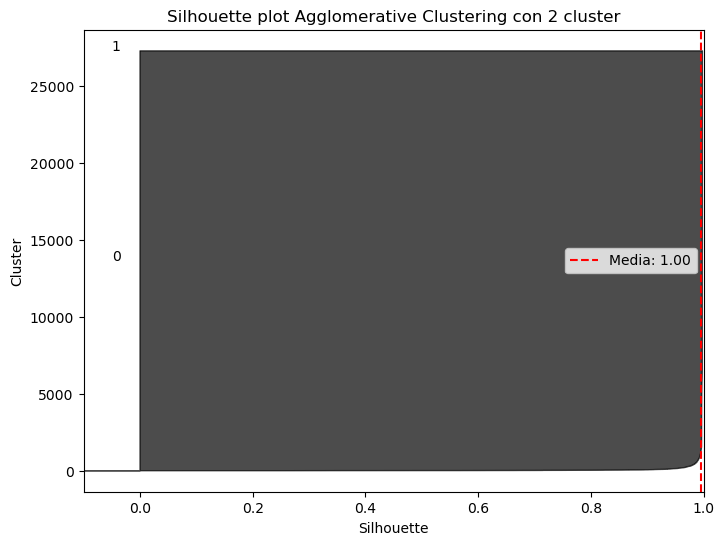

In [66]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples

n_clusters = model.n_clusters
sil_vals = silhouette_samples(df_numeric, labels)

fig, ax = plt.subplots(figsize=(8,6))
y_lower = 10

for i in range(n_clusters):
    vals = np.sort(sil_vals[labels==i])
    y_upper = y_lower + len(vals)
    ax.fill_betweenx(range(y_lower, y_upper), 0, vals,
                     alpha=0.7, color=cm.nipy_spectral(i/n_clusters))
    ax.text(-0.05, y_lower + len(vals)/2, str(i))
    y_lower = y_upper + 10

ax.axvline(sil_score, color="red", linestyle="--", label=f"Media: {sil_score:.2f}")
ax.set_xlim([-0.1, 1])
ax.set_xlabel("Silhouette")
ax.set_ylabel("Cluster")
ax.set_title(f"Silhouette plot Agglomerative Clustering con {n_clusters} cluster")
ax.legend()
plt.show()

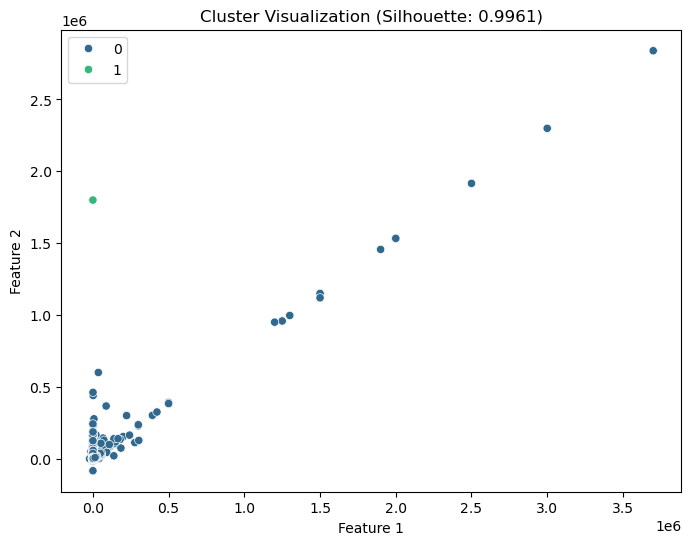

In [64]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_numeric.iloc[:, 0], y=df_numeric.iloc[:, 1], hue=labels, palette='viridis', legend='full')
plt.title(f'Cluster Visualization (Silhouette: {sil_score:.4f})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

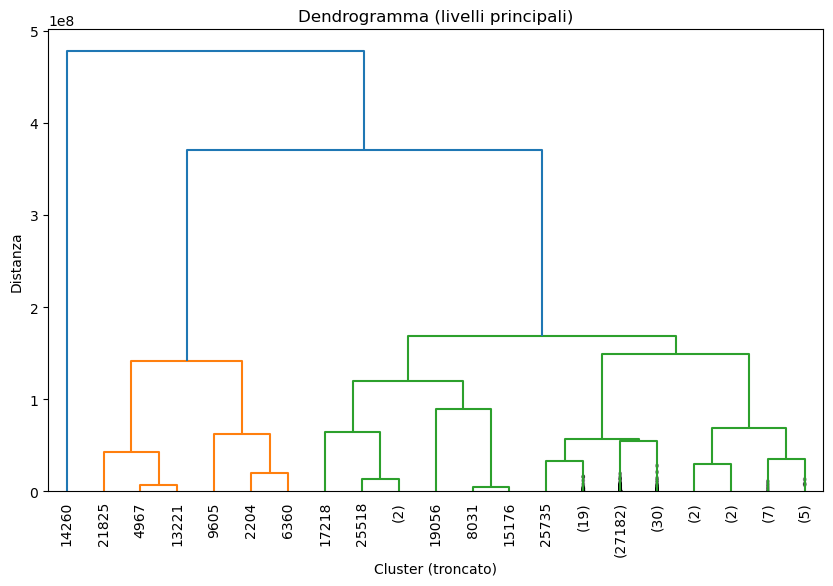

In [65]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linkage_matrix = linkage(df_numeric, method='average')

plt.figure(figsize=(10, 6))
dendrogram(
    linkage_matrix,
    truncate_mode='level',  # mostra solo i livelli superiori
    p=5,                    # numero di livelli da visualizzare
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True
)
plt.title('Dendrogramma (livelli principali)')
plt.xlabel('Cluster (troncato)')
plt.ylabel('Distanza')
plt.show()


## DBSCAN

In [12]:
from sklearn.cluster import DBSCAN

param_grid = {
    'eps': [0.3, 0.5, 0.7],        
    'min_samples': [3, 5, 10],     
    'metric': ['euclidean', 'manhattan']
    }

best_params, results_df = fineTuning(df_numeric, DBSCAN, param_grid)
print("Best parameters:", best_params)

Best parameters: {'eps': 0.3, 'metric': 'euclidean', 'min_samples': 3}


In [13]:
# DBSCAN con i parametri migliori trovati
dbscan = DBSCAN(**best_params)
dbscan.fit(df_numeric)

# Etichette dei cluster
labels_db = dbscan.labels_
unique_labels = np.unique(labels_db)

In [14]:
# Silhouette score (esclude i punti di rumore)
mask = labels_db != -1
sil_score = silhouette_score(df_numeric[mask], labels_db[mask])
print(f"Silhouette Score (escl. rumore): {sil_score:.4f}")

Silhouette Score (escl. rumore): 0.9998


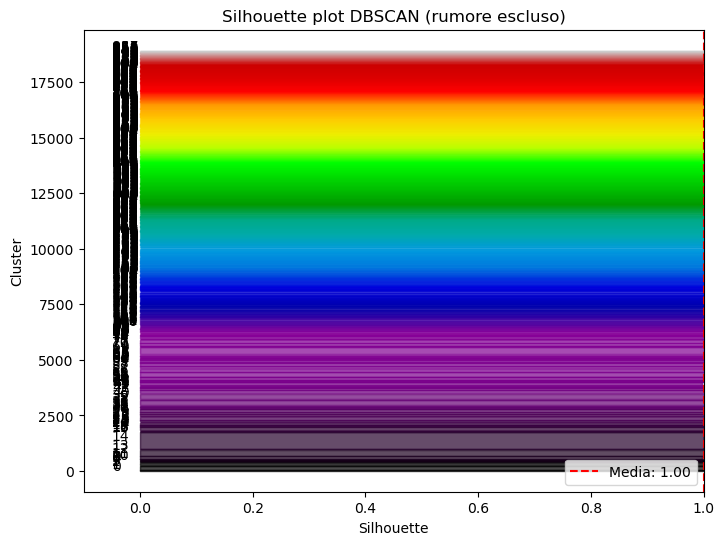

In [71]:
# Silhouette values
sil_vals = silhouette_samples(df_numeric[mask], labels_db[mask])

# Plot
n_clusters = len(unique_labels) - (1 if -1 in labels_db else 0)
fig, ax = plt.subplots(figsize=(8,6))
y_lower = 10

for i, label in enumerate([l for l in unique_labels if l != -1]):
    vals = np.sort(sil_vals[labels_db[mask]==label])
    y_upper = y_lower + len(vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                     alpha=0.7, color=cm.nipy_spectral(i / n_clusters))
    ax.text(-0.05, y_lower + len(vals)/2, str(label))
    y_lower = y_upper + 10

ax.axvline(sil_score, color="red", linestyle="--", label=f"Media: {sil_score:.2f}")
ax.set_xlim([-0.1, 1])
ax.set_xlabel("Silhouette")
ax.set_ylabel("Cluster")
ax.set_title("Silhouette plot DBSCAN (rumore escluso)")
ax.legend()
plt.show()

In [72]:
# Escludi il rumore (-1) dal conteggio dei cluster
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(labels_db == -1)

print(f"Numero di cluster trovati (escludendo rumore): {n_clusters}")
print(f"Numero di punti considerati rumore: {n_noise}")

Numero di cluster trovati (escludendo rumore): 858
Numero di punti considerati rumore: 16931


In [16]:
df_clustered_dbscan = df.copy()
df_clustered_dbscan['Cluster'] = labels_db

display(df_clustered_dbscan[df_clustered_dbscan['Cluster'] == -1])

,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,Subregion,Total Deaths,No. Injured,No. Affected,Total Affected,"Total Damage, Adjusted ('000 US$)",duration_days,Cluster
0,Natural,Meteorological,Storm,Tropical cyclone,United States of America,Northern America,6.000000e+03,4874.178387,4.846190e+05,4.868906e+05,1.131126e+06,1.0,-1
6,Natural,Climatological,Drought,Drought,India,Southern Asia,1.250000e+06,958433.468954,1.833005e+06,8.204566e+05,9.995754e+06,1.0,-1
7,Natural,Climatological,Drought,Drought,Cabo Verde,Sub-Saharan Africa,1.100000e+04,9182.728432,4.902378e+05,4.892261e+05,1.375628e+06,1.0,-1
8,Natural,Biological,Epidemic,Infectious disease (General),Uganda,Sub-Saharan Africa,2.000000e+05,153983.688851,6.950667e+05,5.397528e+05,2.690562e+06,1.0,-1
10,Natural,Geophysical,Earthquake,Tsunami,Japan,Eastern Asia,1.800000e+01,742.101413,-3.006416e+03,2.400000e+01,1.261447e+06,1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27257,Natural,Hydrological,Flood,Flood (General),Ukraine,Eastern Europe,9.000000e+00,633.607917,2.010000e+03,2.010000e+03,1.246058e+06,1.0,-1
27258,Natural,Hydrological,Flood,Flood (General),Bulgaria,Eastern Europe,4.000000e+00,630.184719,1.000000e+02,1.000000e+02,1.245953e+06,1.0,-1
27259,Natural,Climatological,Drought,Drought,Somalia,Sub-Saharan Africa,2.700000e+01,482.000000,-1.373772e+03,4.820000e+02,1.193732e+06,181.0,-1
27260,Natural,Climatological,Drought,Drought,Kenya,Sub-Saharan Africa,3.231126e+03,2572.237988,2.150000e+06,2.150000e+06,1.335056e+06,1.0,-1
